In [306]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
import pennylane as qml
from autograd import grad, jacobian

from pennylane import numpy as pnp
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city

# ==============================
# User defined
# ==============================
from concurrence import *

In [307]:
# ==============================
# Setup for Quantum Computations
# ==============================

# Global variables
PHI_GLOBAL = pnp.zeros(0)

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

### Entangler Layer

In [308]:
@qml.qnode(dev)
def circuit(parameters_in):
    global PHI_GLOBAL
    theta_1 = parameters_in[0]
    theta_2 = parameters_in[1]
    phi = PHI_GLOBAL[0]
    
    qml.RY(theta_1, wires=0)
    qml.RY(theta_1, wires=1)
    
    qml.ApproxTimeEvolution(H, phi, 1)
    
    qml.RY(theta_2, wires=0)
    qml.RY(theta_2, wires=1)
    
    return qml.density_matrix(wires=[0, 1])

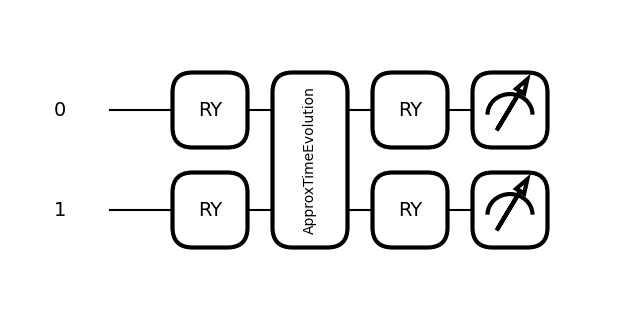

In [309]:
paras_plot = 1,1
PHI_GLOBAL = pnp.array([0])
fig, ax = qml.draw_mpl(circuit)(paras_plot)

### Bell_state Circuit

In [310]:
@qml.qnode(dev)
def bell(phi):
    # if isinstance(parameters_in, np.ndarray) == True:
    #     phi = parameters_in[0]
    # else:
    #     phi = parameters_in
    
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    
    qml.ApproxTimeEvolution(H, phi, 1)
    
    qml.CNOT(wires=[0, 1])
    qml.Hadamard(wires=0)
    
    return qml.density_matrix(wires=[0, 1])

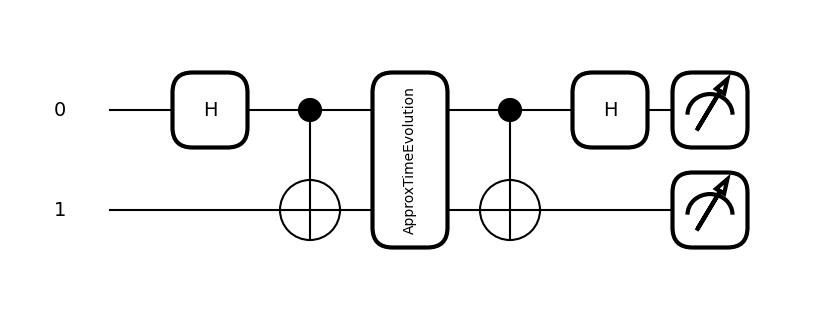

In [311]:
paras_plot = 1,
fig, ax = qml.draw_mpl(bell)(paras_plot)

### Concurrence
The concurrence is an entanglement monotone (a way of measuring entanglement) defined for a mixed state of two qubits.


### Calculation 

Concurrence is defined as:
$$
{\mathcal  {C}}(\rho )\equiv \max(0,\lambda _{1}-\lambda _{2}-\lambda _{3}-\lambda _{4})
$$

where, 
$$
\lambda _{1},...,\lambda _{4}
$$
are the eigenvalues, in decreasing order of matrix R:

$$
R={\sqrt  {{\sqrt  {\rho }}{\tilde  {\rho }}{\sqrt  {\rho }}}}
$$

with,
$$
{\tilde  {\rho }}=(\sigma _{{y}}\otimes \sigma _{{y}})\rho ^{{*}}(\sigma _{{y}}\otimes \sigma _{{y}})
$$

#### Pauli_y
$$
\sigma _{y}={\begin{pmatrix}0&-i\\i&0\end{pmatrix}}
$$


https://en.wikipedia.org/wiki/Concurrence_(quantum_computing)

In [312]:
def get_data_array(circuit_select, sweep_range, parameters_in):
    phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
    data = np.zeros((len(phi),3))
    data[:,0] = phi
    
    global PHI_GLOBAL
    if len(parameters_in) == 1:
        for phi_idx, phi_current in enumerate(phi):
            data[phi_idx][INDEX.CONCURRENCE.value] = calculate_concurrence(circuit_select, phi_current)
            # data[phi_idx][INDEX.CFI.value] = qml.qinfo.classical_fisher(circuit_select)(pnp.array([phi_current], requires_grad = True))
    else:
        for phi_idx, phi_current in enumerate(phi):
            PHI_GLOBAL = pnp.array([phi_current])
            data[phi_idx][INDEX.CONCURRENCE.value] = calculate_concurrence(circuit_select, parameters_in)
            # data[phi_idx][INDEX.CFI.value] = qml.qinfo.classical_fisher(circuit_select)(pnp.array([phi_current], requires_grad = True))

    return data

In [313]:
def calculate_concurrence(circuit_select, parameters_in, test_bell=False):
    # Pauli_y matrix
    pauli_y = pnp.array([
        [0, -1.j], 
        [1.j, 0]
    ])
    
    if test_bell == True:
        rho = get_bell_density_matrix()
    else:
        rho = pnp.array(circuit_select(parameters_in), requires_grad = False)
    rho_unitary = pnp.kron(pauli_y, pauli_y) @ rho.conj() @ pnp.kron(pauli_y, pauli_y)
    
    R = sp.linalg.sqrtm(
        sp.linalg.sqrtm(rho) @ rho_unitary @ sp.linalg.sqrtm(rho)
    )
    
    eig_values = sp.linalg.eigvals(R)
    sort_eig_values = pnp.sort(eig_values.real)[::-1]   # reverse order
    
    sum_of_eig_values = sort_eig_values[0] - pnp.sum(sort_eig_values[1:])
    result_concurrence = pnp.amax(
        [0, sum_of_eig_values]
    )
    
    return result_concurrence
    # return pnp.array(result_concurrence)

In [321]:
phi = np.arange(0, np.pi, 1e-1)
for phi_idx, phi_current in enumerate(phi):
    PHI_GLOBAL = pnp.array([phi_current])
    phi_current = pnp.array(phi_current)
    
    print(calculate_concurrence(bell, phi_current))
    # print(qml.qinfo.classical_fisher(bell)(phi_current))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [315]:
PHI_GLOBAL = pnp.array([np.pi/4])
params = np.array([np.pi, np.pi])
set_sweep_range = np.array([0, np.pi, 1e-1])

calculate_concurrence(circuit, params)

2.7388687357156782e-42

In [316]:
qml.qinfo.classical_fisher(circuit)(pnp.array(params))

tensor([[1.70710678, 1.70710678],
        [1.70710678, 1.70710678]], requires_grad=True)

In [317]:
def cost_function(parameters_in):
    calculate = calculate_concurrence(circuit, parameters_in)
    
    return -calculate*1e+10

In [318]:
cost_function(params)

-2.7388687357156784e-32

In [319]:
optimization_result = sp.optimize.minimize(
        fun = cost_function, 
        x0 = params, 
        method = 'L-BFGS-B', 
        # bounds = constraints,
        tol = 1e-12,
        options={
            'ftol': 1e-12, 
            'gtol': 1e-12
        }
    )

optimization_result

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -14.818482665323586
        x: [ 3.724e+00  3.955e+00]
      nit: 3
      jac: [ 2.181e+09  1.712e+09]
     nfev: 231
     njev: 77
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [320]:
phi = np.arange(set_sweep_range[0],set_sweep_range[1],set_sweep_range[2])
data = np.zeros((len(phi), len(params) + 2))
data[:, 0] = phi

constraints = [(-float('inf'), float('inf'))] * len(params)

# global PHI_GLOBAL
for phi_idx, phi_current in enumerate(phi):
    PHI_GLOBAL = pnp.array([phi_current]) 
    
    optimization_result = sp.optimize.minimize(
        fun = cost_function, 
        x0 = params, 
        method = 'L-BFGS-B', 
        # bounds = constraints,
        tol = 1e-12,
        options={
            'ftol': 1e-12, 
            'gtol': 1e-12
        }
    )
    
    data[phi_idx][INDEX.CONCURRENCE.value] = -optimization_result.fun
    data[phi_idx][INDEX.PARAS_START.value:] = optimization_result.x

KeyboardInterrupt: 

In [ ]:
data

array([[0.00000000e+00, 3.11500097e+00, 4.14158972e+00, 3.14159265e+00],
       [1.00000000e-01, 4.25074813e-01, 3.80825933e+00, 3.14159265e+00],
       [2.00000000e-01, 4.78444399e+00, 4.14159265e+00, 3.14159265e+00],
       [3.00000000e-01, 3.93506204e+01, 3.31774983e+00, 4.12595471e+00],
       [4.00000000e-01, 2.41937609e+00, 4.14027141e+00, 3.19298088e+00],
       [5.00000000e-01, 4.77904286e+00, 4.14159265e+00, 3.14159265e+00],
       [6.00000000e-01, 6.03191556e-01, 7.70018417e+00, 3.14159278e+00],
       [7.00000000e-01, 3.85784363e+01, 3.23036528e+00, 3.80232233e+00],
       [8.00000000e-01, 3.91497171e+00, 4.88153942e+00, 3.14159291e+00],
       [9.00000000e-01, 5.11605813e+00, 4.03652195e+00, 8.06085089e+00],
       [1.00000000e+00, 4.32804109e+01, 7.82188574e+00, 3.14159265e+00],
       [1.10000000e+00, 5.23500005e+00, 3.32733823e+00, 4.12410720e+00],
       [1.20000000e+00, 8.56298292e+00, 3.95477926e+00, 3.14159306e+00],
       [1.30000000e+00, 1.52715570e+01, 3.42238675e

In [ ]:
def concurrence_optimization(sweep_range, initial_parameters):
    phi = np.arange(sweep_range[0],sweep_range[1],sweep_range[2])
    data = np.zeros((len(phi), len(initial_parameters) + 2))
    data[:, 0] = phi
    
    global PHI_GLOBAL
    for phi_idx, phi_current in enumerate(phi):
        PHI_GLOBAL = pnp.array([phi_current]) 
        
        optimization_result = lbfgsb(cost_function, initial_parameters, grad(cost_function))
        
        data[phi_idx][INDEX.CONCURRENCE.value] = -optimization_result.fun
        data[phi_idx][INDEX.PARAS_START.value:] = optimization_result.x
        
    return data

concurrence_optimization(set_sweep_range, params)

AttributeError: 'ArrayBox' object has no attribute 'conj'